In this notebook we scale the speed object algorithm for multiple objects.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import os
from tqdm import tqdm
from sklearn import linear_model
import pandas as pd
from math import sqrt

In [2]:
# REFERENCE: https://www.carwow.co.uk/guides/glossary/what-is-a-car-wheelbase-0282
WHEEL_BASE = 2.43 #IN METERS
DISTANCE_ERROR_THRESHOLD = 5

In [3]:
f = open("/code/data/datasets/common_hall/tracking_outputs/framewise_aggregation.json")
frame_to_predictions_map = json.load(f)
f = open("/code/data/datasets/common_hall/tracking_outputs/objectwise_aggregation.json")
objects_to_predictions_map = json.load(f)['annotations'] #the object_id attribute of frame_to_predictions_map are the keys of object_to_predictions_map

In [4]:
def validate_inclusion(_x, _y, _cx, _cy, _r):
    return (_x - _cx)**2 + (_y -_cy)**2 < _r**2

In [5]:
def get_distance(_x1, _y1, _x2, _y2):
    return sqrt((_x1 -_x2)**2 + (_y1 -_y2)**2)

In [6]:
def frames_to_seconds(_fps, _n_frames):
    return (1/_fps * _n_frames)

In [7]:
frame_path = '/code/data/datasets/frame_imgs'
frame_list = os.listdir(frame_path)
frame_border = False
rule0 = False
rule1 = False
rule2 = False
def get_objectwise_keypoints(rule0, rule1, rule2):
    objectwise_keypoints = {}
    for i in range(len(objects_to_predictions_map)):
        objectwise_keypoints[objects_to_predictions_map[i]['id']] = []
    for frame_idx in range(len(frame_to_predictions_map)):
        frame = cv2.imread(str(Path(frame_path)/frame_list[i]))
        if frame_border:
            img = cv2.rectangle(frame, (450, 200), (1280, 720), (0, 255, 0), thickness=4)
        objects_per_frame = frame_to_predictions_map[frame_idx]['annotations']
        for obj_idx in range(len(objects_per_frame)):
            back_tire_x = objects_per_frame[obj_idx]['keypoints'][0][0]
            back_tire_y =objects_per_frame[obj_idx]['keypoints'][0][1]
            front_tire_x = objects_per_frame[obj_idx]['keypoints'][1][0]
            front_tire_y = objects_per_frame[obj_idx]['keypoints'][1][1]
            x1, y1, x2, y2 = objects_per_frame[obj_idx]['bounding_box']
            #rule #0
            if rule0 == True:
                frame_save_path = Path('/code/data/datasets/rule0_imgs')
                if x1 < 600 or x1>= 1100:
                    back_tire_x = -100
                    back_tire_y = -100
                    front_tire_x = -100
                    front_tire_y = -100

            #rule #1
            if rule1 == True:
                frame_save_path = Path('/code/data/datasets/rule1_imgs')
                if (back_tire_y <= y1 + int((y2 - y1)/2)):
                    back_tire_x = -100
                    back_tire_y = -100
                if (front_tire_y <= y1 + int((y2 - y1)/2)):
                    front_tire_x = -100
                    front_tire_y = -100
            #rule #2
            if rule2 == True:
                frame_save_path = Path('/code/data/datasets/rule2_imgs')
                if validate_inclusion(back_tire_x, back_tire_y, front_tire_x, front_tire_y, 20):
                    if np.array(objects_per_frame[obj_idx]['keypoints_scores']).argmax() == 0:
                        front_tire_x = -100
                        front_tire_y = -100
                    else:
                        back_tire_x = -100
                        back_tire_y = -100
            # img = cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), thickness=4)
            # img = cv2.circle(img, (int(back_tire_x), int(back_tire_y)), radius=5, color=(0, 0, 255), thickness=-1) #Blue: Backtire
            # img = cv2.circle(img, (int(front_tire_x), int(front_tire_y)), radius=5, color=(255, 0, 0), thickness=-1) #Red Front tire
            # cv2.imwrite(os.path.join(frame_save_path, f'{frame_idx}.jpg'), img)
            # back_tire_x_list.append(back_tire_x)
            # back_tire_y_list.append(back_tire_y)
            # front_tire_x_list.append(front_tire_x)
            # front_tire_y_list.append(front_tire_y)
            objectwise_keypoints[objects_per_frame[obj_idx]['object_tracklet_id']].append((back_tire_x, back_tire_y, front_tire_x, front_tire_y))
    return objectwise_keypoints


In [8]:
objectwise_keypoints = get_objectwise_keypoints(True, True, True)
object_names = list(objectwise_keypoints.keys())

In [9]:
vehicle_keypoints = {}
for obj_idx in range(len(object_names)):
    dont_care_count = 0
    object_name = object_names[obj_idx]
    noisy_vehicle_keypoints = objectwise_keypoints[object_names[obj_idx]]
    for vehicle_keypoint_pair in noisy_vehicle_keypoints:
        back_x, back_y, front_x, front_y = vehicle_keypoint_pair
        if back_x < 0 and front_x < 0:
            dont_care_count += 1
    dont_care_percentage = dont_care_count*100/ len(noisy_vehicle_keypoints)# calculate the noise percentage
    if dont_care_percentage == 100:#throw away if noise percentage is 100
        continue
    else:
        vehicle_keypoints[obj_idx] = noisy_vehicle_keypoints
vehicle_indices = list(vehicle_keypoints.keys())

In [10]:
speed_collection = {}
for vehicle_index in vehicle_indices:#Looping through all objects in the video
    approximate_speed = -1
    back_tire_x_list = []
    back_tire_y_list = []
    front_tire_x_list = []
    front_tire_y_list = []
    object_name = object_names[vehicle_index]
    for keypoints_per_frame in objectwise_keypoints[object_name]:
        back_tire_x, back_tire_y, front_tire_x, front_tire_y = keypoints_per_frame
        back_tire_x_list.append(back_tire_x)
        back_tire_y_list.append(back_tire_y)
        front_tire_x_list.append(front_tire_x)
        front_tire_y_list.append(front_tire_y)
    #
    data = {"back_tire_x":back_tire_x_list, "back_tire_y":back_tire_y_list, "front_tire_x":front_tire_x_list, "front_tire_y":front_tire_y_list}
    df = pd.DataFrame(data)
    df.drop(df[df.back_tire_x < 0].index, inplace=True)
    df.drop(df[df.front_tire_x < 0].index, inplace=True)
    x = df.iloc[:, :-1]
    y = df.iloc[:, -1:]
    #
    model = linear_model.LinearRegression()
    model.fit(x, y)
    coef = model.coef_[0]
    bias = model.intercept_
    #
    back_tire_x_list = []
    back_tire_y_list = []
    front_tire_x_list = []
    front_tire_y_list = []
    for i in range(len(data['back_tire_x'])):
        back_tire_x = data['back_tire_x'][i]
        back_tire_y = data['back_tire_y'][i]
        front_tire_x = data['front_tire_x'][i]
        front_tire_y = data['front_tire_y'][i]
        if (back_tire_x < 0 and back_tire_y < 0) and (front_tire_x < 0 and front_tire_y < 0):
            back_tire_x_list.append(back_tire_x)
            back_tire_y_list.append(back_tire_y)
            front_tire_x_list.append(front_tire_x)
            front_tire_y_list.append(front_tire_y)
            continue
        if back_tire_x < 0:
            back_tire_x = (front_tire_y - back_tire_y * coef[1] - front_tire_x* coef[2] - bias)/coef[0]
        if back_tire_y < 0:
            back_tire_y = (front_tire_y - back_tire_x * coef[0] - front_tire_x* coef[2] - bias)/coef[1]
        if front_tire_x < 0:
            front_tire_x = (front_tire_y - back_tire_x * coef[0] - back_tire_y * coef[1] - bias)/coef[2]
        if front_tire_y < 0:
            front_tire_y = back_tire_x * coef[0] + back_tire_y * coef[1] + front_tire_x* coef[2] + bias

        back_tire_x_list.append(back_tire_x)
        back_tire_y_list.append(back_tire_y)
        front_tire_x_list.append(front_tire_x)
        front_tire_y_list.append(front_tire_y)
    #

    vehicle_speed = []
    skipped = 0

    back_tire_keypoints = [back_tire_x_list, back_tire_y_list]
    back_tire_keypoints = [list(x) for x in zip(*back_tire_keypoints[::-1])]
    front_tire_keypoints = [front_tire_x_list, front_tire_y_list]
    front_tire_keypoints = [list(x) for x in zip(*front_tire_keypoints[::-1])]

    back_tire_x_list = []
    back_tire_y_list = []
    front_tire_x_list = []
    front_tire_y_list = []
    speed_checkpoints = []
    #
    vehicle_speed = {}
    total_num_points = len(objectwise_keypoints[object_name])
    for i in range(total_num_points):
        back_tire = back_tire_keypoints[i]
        front_tire = front_tire_keypoints[i]
        if back_tire[0] < 0 or front_tire[0] <0:
            vehicle_speed[i] = approximate_speed
            skipped+=1
            continue
        for j in range(i,total_num_points):
            future_back_tire = back_tire_keypoints[j]
            if future_back_tire[0] < 0:
                continue
            back_tire_x = back_tire[0]
            back_tire_y = back_tire[1]
            front_tire_x = front_tire[0]
            front_tire_y = front_tire[1]
            future_back_tire_x = future_back_tire[0]
            future_back_tire_y = future_back_tire[1]
            current_keypoints_distance = get_distance(back_tire_x, back_tire_y, front_tire_x, front_tire_y)
            future_keypoints_distance = get_distance(back_tire_x, back_tire_y, future_back_tire_x, future_back_tire_y)
            if  current_keypoints_distance <= future_keypoints_distance:
                if (future_keypoints_distance - current_keypoints_distance) < DISTANCE_ERROR_THRESHOLD:
                    approximate_speed = round(WHEEL_BASE / frames_to_seconds(30, j - i))
                    vehicle_speed[i] = approximate_speed
                    back_tire_x_list.append(back_tire_x)
                    back_tire_y_list.append(back_tire_y)
                    front_tire_x_list.append(front_tire_x)
                    front_tire_y_list.append(front_tire_y)
                break
    speed_collection[vehicle_index] = vehicle_speed
        
    


    


/tmp/ipykernel_1551656/2883416778.py:48: RuntimeWarning: divide by zero encountered in divide
  front_tire_x = (front_tire_y - back_tire_x * coef[0] - back_tire_y * coef[1] - bias)/coef[2]
/tmp/ipykernel_1551656/2883416778.py:50: RuntimeWarning: invalid value encountered in multiply
  front_tire_y = back_tire_x * coef[0] + back_tire_y * coef[1] + front_tire_x* coef[2] + bias
/tmp/ipykernel_1551656/2883416778.py:44: RuntimeWarning: divide by zero encountered in divide
  back_tire_x = (front_tire_y - back_tire_y * coef[1] - front_tire_x* coef[2] - bias)/coef[0]
/tmp/ipykernel_1551656/2883416778.py:46: RuntimeWarning: invalid value encountered in multiply
  back_tire_y = (front_tire_y - back_tire_x * coef[0] - front_tire_x* coef[2] - bias)/coef[1]
/tmp/ipykernel_1551656/3395897111.py:2: RuntimeWarning: invalid value encountered in subtract
  return sqrt((_x1 -_x2)**2 + (_y1 -_y2)**2)


In [15]:
speed_collection.keys()

dict_keys([0, 1, 3, 4])

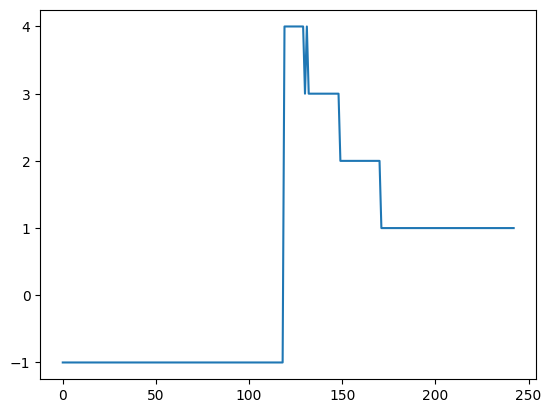

In [24]:
plt.plot(speed_collection[4].values())